# Original Function

# 2nd Function Test

In [50]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
from scipy.spatial.distance import cdist
import numpy as np

"""import glob
import gzip
import bz2"""
import os
#import _pickle as cPickle

import io
import matplotlib.pyplot as plt

import joblib  # Ensure this import is at the beginning of your script

MODEL_DIR = "../dev_tox/models"  # Directory where models are stored

MODEL_DICT = {
    'Overall Toxicity': [os.path.join(MODEL_DIR, 'ECFP4_overall_tox_svm.joblib')],
    'First Trimester Toxicity': [os.path.join(MODEL_DIR, 'ECFP4_first_trimester_svm.joblib')],
    'Second Trimester Toxicity': [os.path.join(MODEL_DIR, 'ECFP4_second_trimester_svm.joblib')],
    'Third Trimester Toxicity': [os.path.join(MODEL_DIR, 'ECFP4_third_trimester_svm.joblib')],
}


# lol I'm just like screw code readability sorry
MODEL_DICT_INVERT = {v: key for key, val in MODEL_DICT.items() for v in val}

CLASSIFICATION_DICT = {
    'Overall Toxicity': {
        0: "Non-toxic",
        1: "Toxic"
    },
    'First Trimester Toxicity': {
        0: "Non-toxic",
        1: "Toxic"
    },
    'Second Trimester Toxicity': {
        0: "Non-toxic",
        1: "Toxic"
    },
    'Third Trimester Toxicity': {
        0: "Non-toxic",
        1: "Toxic"
    },
    }


AD_DICT = {
    True: "Inside",
    False: "Outside"
}


def run_prediction(model, smi, selected_features_file, calculate_ad=True, threshold=0.5):
    """_summary_

    Args:
        model (_type_): _description_
        smi (_type_): _description_
        selected_features_file (str): Path to the selected features file.
        calculate_ad (bool, optional): _description_. Defaults to True.
        threshold (float, optional): Decision threshold for toxicity classification.

    Returns:
        tuple: Prediction, prediction probability, and applicability domain status.
    """
    # Generate the molecular fingerprint with 2048 bits
    fp = np.zeros((2048, 1))
    _fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2, nBits=2048, useFeatures=False)
    DataStructs.ConvertToNumpyArray(_fp, fp)

    # Load the selected features indices from the correct file
    selected_features = np.load(selected_features_file)

    # Ensure fp is reshaped to one-dimensional
    fp = fp.flatten()
    
    # Select only the features that were used during model training
    fp_selected = fp[selected_features]

    # Make the prediction using the model
    pred_proba = model.predict_proba(fp_selected.reshape(1, -1))[:, 1]
    pred = 1 if pred_proba > threshold else 0

    # Adjust probability if the prediction is non-toxic
    if pred == 0:
        pred_proba = 1 - float(pred_proba)

    return pred, pred_proba, None



def get_prob_map(model, smi, selected_features_file):
    """Generates a probability map for a given molecule.

    Args:
        model: The trained model.
        smi: The SMILES string for the molecule.
        selected_features_file (str): Path to the selected features file.

    Returns:
        SVG string representing the probability map.
    """
    # Load the selected features indices from the correct file
    selected_features = np.load(selected_features_file)

    def get_fp(mol, idx):
        """Generates the fingerprint for the molecule at a specific atom index."""
        fps = np.zeros((2048, 1))
        _fps = SimilarityMaps.GetMorganFingerprint(mol, idx, radius=3, nBits=2048)
        DataStructs.ConvertToNumpyArray(_fps, fps)

        # Ensure fps is reshaped to one-dimensional
        fps = fps.flatten()

        # Select only the features that were used during model training
        fps_selected = fps[selected_features]

        return fps_selected

    def get_proba(fps):
        """Gets the probability prediction for a specific fingerprint."""
        return float(model.predict_proba(fps.reshape(1, -1))[:, 1])

    mol = Chem.MolFromSmiles(smi)
    fig, _ = SimilarityMaps.GetSimilarityMapForModel(mol, get_fp, get_proba)
    imgdata = io.StringIO()
    fig.savefig(imgdata, format='svg')
    imgdata.seek(0)  # rewind the data

    return imgdata.getvalue()


def main(smi, calculate_ad=True, make_prop_img=False, **kwargs):
    values = {}

    for key, val in kwargs.items():
        if key in MODEL_DICT.keys():  # check if this kwarg is for a model
            if val:  # check if model is turned on
                model_file = MODEL_DICT[key][0]  # Get the model file path
                print(f"Loading model from: {model_file}")
                
                # Load model and threshold from the joblib file
                model_data = joblib.load(model_file)
                model = model_data['model']  # Extract model
                threshold = model_data.get('threshold', 0.5)  # Extract threshold or default to 0.5
                
                # Determine the correct selected features file based on the model type
                if key == 'Overall Toxicity':
                    selected_features_file = os.path.join(MODEL_DIR, 'selected_features_overall_tox_ecfp4.npy')
                elif key == 'First Trimester Toxicity':
                    selected_features_file = os.path.join(MODEL_DIR, 'selected_features_first_tri_ecfp4.npy')
                elif key == 'Second Trimester Toxicity':
                    selected_features_file = os.path.join(MODEL_DIR, 'selected_features_second_tri_ecfp4.npy')
                elif key == 'Third Trimester Toxicity':
                    selected_features_file = os.path.join(MODEL_DIR, 'selected_features_third_tri_ecfp4.npy')
                else:
                    raise ValueError(f"Unknown model type: {key}")

                # Run the prediction with the correct selected features file
                pred, pred_proba, ad = run_prediction(model, smi, selected_features_file, calculate_ad=calculate_ad, threshold=threshold)

                contrib_svg_str = ""
                if make_prop_img:
                    # Correctly pass the third argument to get_prob_map
                    contrib_svg_str = get_prob_map(model, smi, selected_features_file)

                values[key] = [pred, pred_proba, ad, contrib_svg_str]
        
    processed_results = []
    for key, val in values.items():
        processed_results.append([key, CLASSIFICATION_DICT[key][val[0]], val[1], val[2], val[3]])

    return processed_results


In [10]:
import os
print("Current Working Directory:", os.getcwd())



Current Working Directory: /Users/scheufentieghr2/Documents/GitHub/dev-tox-V2/dev_tox


In [32]:
# Initialize the smiles string
smiles_string = "C(C(CBr)Br)Cl"

# Initialize a list to store results
results_array = []

# Define the predictions to be made
toxicity_predictions = [
    {"Overall Toxicity": True},
    {"First Trimester Toxicity": True},
    {"Second Trimester Toxicity": True},
    {"Third Trimester Toxicity": True}
]

# Iterate over each prediction type and collect the results
for prediction in toxicity_predictions:
    result = main(smi=smiles_string, calculate_ad=False, make_prop_img=False, **prediction)
    results_array.append(result)

# Print the results array
print(results_array)

#ignore warning
import warnings
warnings.filterwarnings("ignore")
#ignore deperecation warning
warnings.filterwarnings("ignore", category=DeprecationWarning)

Loading model from: ../dev_tox/models/ECFP4_overall_tox_svm.joblib
Loading model from: ../dev_tox/models/ECFP4_first_trimester_svm.joblib
Loading model from: ../dev_tox/models/ECFP4_second_trimester_svm.joblib
Loading model from: ../dev_tox/models/ECFP4_third_trimester_svm.joblib
[[['Overall Toxicity', 'Non-toxic', 0.7857068273493529, None, '']], [['First Trimester Toxicity', 'Toxic', array([0.92827325]), None, '']], [['Second Trimester Toxicity', 'Toxic', array([0.99999097]), None, '']], [['Third Trimester Toxicity', 'Toxic', array([0.99074376]), None, '']]]


[15:53:43] DEPRECATION WARNING: please use MorganGenerator
[15:53:43] DEPRECATION WARNING: please use MorganGenerator
[15:53:43] DEPRECATION WARNING: please use MorganGenerator
[15:53:43] DEPRECATION WARNING: please use MorganGenerator


In [33]:
model = joblib.load("models/ECFP4_overall_tox_svm.joblib")
print(type(model))  # Check the type of the loaded model


<class 'dict'>


# Testing AD Functionality

In [34]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import os
import pickle
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist


def _get_AD_thresh(fps, file_name):
    dists = pdist(fps)
    mean_1 = dists.mean()
    dists_2 = dists[np.where(dists < mean_1)]
    mean_2 = dists_2.mean()
    std_2 = dists_2.std()

    threshold = mean_2 + (0.5 * std_2)

    pickle.dump((threshold, fps),  open(file_name, "wb"))

def read_sdf_and_save_ad_file(sdf_file, output_file):
    suppl = Chem.SDMolSupplier(sdf_file)
    molecules = [mol for mol in suppl if mol is not None]

    fps = np.array([list(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, useFeatures=False))
                    for mol in molecules])

    _get_AD_thresh(fps, output_file)




In [35]:
fname1 = "/Users/scheufentieghr2/Documents/GitHub/DT_Modelling/data/DT_overall_tox_sdf_final.sdf"
fname2 = "/Users/scheufentieghr2/Documents/GitHub/DT_Modelling/data/DT_first_trimester_tox_sdf_final.sdf"
fname3 = "/Users/scheufentieghr2/Documents/GitHub/DT_Modelling/data/DT_second_trimester_tox_sdf_final.sdf"
fname4 = "/Users/scheufentieghr2/Documents/GitHub/DT_Modelling/data/DT_third_trimester_tox_sdf_final.sdf"


In [36]:
# Overall FPs
MODEL_DIR = os.path.join(os.path.dirname("/Users/scheufentieghr2/Documents/GitHub/dev-tox-V2/dev_tox"), "models")  # Directory where models are stored
sdf_file = fname1  # Replace with your SDF file path
output_file = os.path.join(MODEL_DIR, 'overall_toxicity_AD.pkl')  # Replace 'your_model_AD.pkl' with your desired output file name

read_sdf_and_save_ad_file(sdf_file, output_file)

[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerator
[15:53:46] DEPRECATION WARNING: please use MorganGenerat

In [37]:
# First TM FPs
MODEL_DIR = os.path.join(os.path.dirname("/Users/scheufentieghr2/Documents/GitHub/dev-tox-V2/dev_tox"), "models")  # Directory where models are stored
sdf_file = fname2  # Replace with your SDF file path
output_file = os.path.join(MODEL_DIR, 'first_tri_toxicity_AD.pkl')  # Replace 'your_model_AD.pkl' with your desired output file name

read_sdf_and_save_ad_file(sdf_file, output_file)

[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerat

In [38]:
# Second TM FPs
MODEL_DIR = os.path.join(os.path.dirname("/Users/scheufentieghr2/Documents/GitHub/dev-tox-V2/dev_tox"), "models")  # Directory where models are stored
sdf_file = fname3  # Replace with your SDF file path
output_file = os.path.join(MODEL_DIR, 'second_tri_toxicity_AD.pkl')  # Replace 'your_model_AD.pkl' with your desired output file name

read_sdf_and_save_ad_file(sdf_file, output_file)

[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerat

In [39]:
# Third TM FPs
MODEL_DIR = os.path.join(os.path.dirname("/Users/scheufentieghr2/Documents/GitHub/dev-tox-V2/dev_tox"), "models")  # Directory where models are stored
sdf_file = fname4  # Replace with your SDF file path
output_file = os.path.join(MODEL_DIR, 'third_tri_toxicity_AD.pkl')  # Replace 'your_model_AD.pkl' with your desired output file name

read_sdf_and_save_ad_file(sdf_file, output_file)

[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerator
[15:53:47] DEPRECATION WARNING: please use MorganGenerat

In [40]:
import pickle
import os

# Assuming your function 'read_sdf_and_save_ad_file' has already been run and the output file has been created

# Path to the output file
MODEL_DIR = os.path.join(os.path.dirname("/Users/scheufentieghr2/Documents/GitHub/dev-tox-V2/dev_tox"), "models")
output_file = os.path.join(MODEL_DIR, 'third_tri_toxicity_AD.pkl')

# Load the output file
with open(output_file, 'rb') as file:
    data = pickle.load(file)

# Check and print the type of data
print(f"Type of the data in the file: {type(data)}")

# If you want to see more details about the content (like length if it's a list or tuple)
if isinstance(data, (list, tuple)):
    print(f"Length of the data: {len(data)}")
    # To show the type of the first element in the tuple/list
    print(f"Type of the first element: {type(data[0])}")


Type of the data in the file: <class 'tuple'>
Length of the data: 2
Type of the first element: <class 'numpy.float64'>


In [41]:


def _get_AD_thresh(training_smiles, file_name):
    fps = np.array([list(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2, nBits=2048, useFeatures=False))
                    for smi in training_smiles])

    dists = pdist(fps)
    mean_1 = dists.mean()
    dists_2 = dists[np.where(dists < mean_1)]
    mean_2 = dists_2.mean()
    std_2 = dists_2.std()

    threshold = mean_2 + (0.5 * std_2)

    import pickle
    pickle.dump((threshold, fps),  open(file_name, "wb"))


def calc_ad(query_fp, ad_tuple):
    dist = cdist(query_fp, ad_tuple[1], "euclidean")
    return dist < ad_tuple[0]


def run_prediction(model, smi, calculate_ad=True, ad_tup=None, threshold=0.5):
    """_summary_

    Args:
        model (_type_): _description_
        model_data (_type_): _description_
        smi (_type_): _description_
        calculate_ad (bool, optional): _description_. Defaults to True.

    Returns:
        _type_: _description_
    """
    fp = np.zeros((2048, 1))
    # sub in your FP function
    _fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2, nBits=2048, useFeatures=False)
    DataStructs.ConvertToNumpyArray(_fp, fp)

    pred_proba = model.predict_proba(fp.reshape(1, -1))[:, 1]
    pred = 1 if pred_proba > threshold else 0

    if pred == 0:
        pred_proba = 1 - float(pred_proba)

    # used to get proba of the inactive class if deemed inactive
    # if pred == 0:
    #     pred_proba = 1-pred_proba

    if calculate_ad:
        ad = calc_ad(fp, ad_tup)
        return pred, pred_proba, ad

    return pred, float(pred_proba), ""


def get_prob_map(model, smi):
    def get_fp(mol, idx):
        fps = np.zeros((2048, 1))
        _fps = SimilarityMaps.GetMorganFingerprint(mol, idx, radius=3, nBits=2048)
        DataStructs.ConvertToNumpyArray(_fps, fps)
        return fps

    def get_proba(fps):
        return float(model.predict_proba(fps.reshape(1, -1))[:, 1])

    mol = Chem.MolFromSmiles(smi)
    fig, _ = SimilarityMaps.GetSimilarityMapForModel(mol, get_fp, get_proba)
    imgdata = io.StringIO()
    fig.savefig(imgdata, format='svg')
    imgdata.seek(0)  # rewind the data
    plt.savefig(imgdata, format="svg", bbox_inches="tight")

    return imgdata.getvalue()


def main(smi, calculate_ad=True, make_prop_img=False, **kwargs):
    values = {}

    for key, val in kwargs.items():
        if key in MODEL_DICT.keys():  # check if this kwarg is for a model
            if val:  # check if model is turned on
                model = MODEL_DICT[key][0]  # Get the model file path
                ad_tup = AD_DICT[key][0]
                # print(f"Loading model from: {model_file}")
                # model = joblib.load(model_file)  # load the model

                pred, pred_proba, ad = run_prediction(model, smi, calculate_ad=calculate_ad, ad_tup=ad_tup)

                contrib_svg_str = ""
                if make_prop_img:
                    contrib_svg_str = get_prob_map(model, smi)

                values[key] = [pred, float(pred_proba), AD_DICT[ad > AD_THRESH], contrib_svg_str]

    processed_results = []
    for key, val in values.items():
        processed_results.append([key, CLASSIFICATION_DICT[key][val[0]], val[1], val[2], val[3]])

    return processed_results


# def write_csv_file(smiles_list, calculate_ad=False):
#     headers = list(MODEL_DICT.keys())
#
#     if calculate_ad:
#         headers = headers + [_ + "_AD" for _ in headers]
#
#     string_file = StringIO()
#     writer = csv.DictWriter(string_file, fieldnames=['SMILES', *headers])
#     writer.writeheader()
#
#     for smiles in tqdm(smiles_list):
#         molecule = MolFromSmiles(smiles)
#
#         row = {'SMILES': smiles}
#
#         if molecule is None:
#             row['SMILES'] = f"(invalid){smiles}"
#             writer.writerow(row)
#             continue
#
#         data = main(smiles, calculate_ad=calculate_ad, **MODEL_DICT)
#
#         for model_name, pred, pred_proba, ad, _ in data:
#             try:
#                 pred_proba = float(pred_proba[:-1]) / 100  # covert back to 0-1 float
#                 row[
#                     model_name] = pred_proba if pred == 1 else 1 - pred_proba  # this is to make sure its proba for class 1
#             except ValueError:
#                 row[model_name] = "No prediction"  # if pred_proba is string skip
#             if calculate_ad:
#                 row[model_name + "_AD"] = ad
#
#         writer.writerow(row)
#
#     return string_file.getvalue()


# if __name__ == "__main__":
#     import argparse
#     import csv
#     from io import StringIO
#     from rdkit.Chem import MolFromSmiles
#     from tqdm import tqdm
#
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--infile", type=str, required=True,
#                         help="location to csv of SMILES")
#     parser.add_argument("--outfile", type=str, default=os.path.join(os.getcwd(), "phakin_output.csv"),
#                         help="location and file name for output")
#     parser.add_argument("--smiles_col", type=str, default="SMILES",
#                         help="column name containing SMILES of interest"),
#     parser.add_argument("--ad", action="store_true",
#                         help="calculate the AD")


In [42]:
import pickle

# Load the AD data from the .pkl file
ad_file_path = "../models/overall_toxicity_AD.pkl"  # Replace with your .pkl file path
with open(ad_file_path, 'rb') as f:
    ad_data = pickle.load(f)

# Process the query molecule
query_smiles = "C1=NC(=NC(=O)N1C2C(C(C(O2)CO)O)O)N"  # Example query molecule (Benzene)
query_mol = Chem.MolFromSmiles(query_smiles)
query_fp = np.array(AllChem.GetMorganFingerprintAsBitVect(query_mol, radius=2, nBits=2048, useFeatures=False))

# Convert query_fp to 2D array for cdist
query_fp_2d = query_fp[np.newaxis, :]  # Makes it 2-dimensional

# Check if the query molecule is within the AD
is_within_ad = calc_ad(query_fp_2d, ad_data)
print(f"Molecule is within the AD: {is_within_ad.any()}")


Molecule is within the AD: True


[15:53:49] DEPRECATION WARNING: please use MorganGenerator


# Test GetProb map

Testing get_prob_map for Overall Toxicity...


[15:58:09] DEPRECATION WARNING: please use MorganGenerator


Successfully generated similarity map for Overall Toxicity.
Sample of SVG output:
<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg xmlns:xlink="http://www.w3.org/1999/xli...

Testing get_prob_map for First Trimester Toxicity...
Successfully generated similarity map for First Trimester Toxicity.
Sample of SVG output:
<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg xmlns:xlink="http://www.w3.org/1999/xli...

Testing get_prob_map for Second Trimester Toxicity...
Successfully generated similarity map for Second Trimester Toxicity.
Sample of SVG output:
<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg xmlns:xlink="http://www.w3.org/1999/xli...

Testing get_pro

[15:58:09] DEPRECATION WARNING: please use MorganGenerator
[15:58:09] DEPRECATION WARNING: please use MorganGenerator
[15:58:09] DEPRECATION WARNING: please use MorganGenerator


Successfully generated similarity map for Third Trimester Toxicity.
Sample of SVG output:
<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg xmlns:xlink="http://www.w3.org/1999/xli...



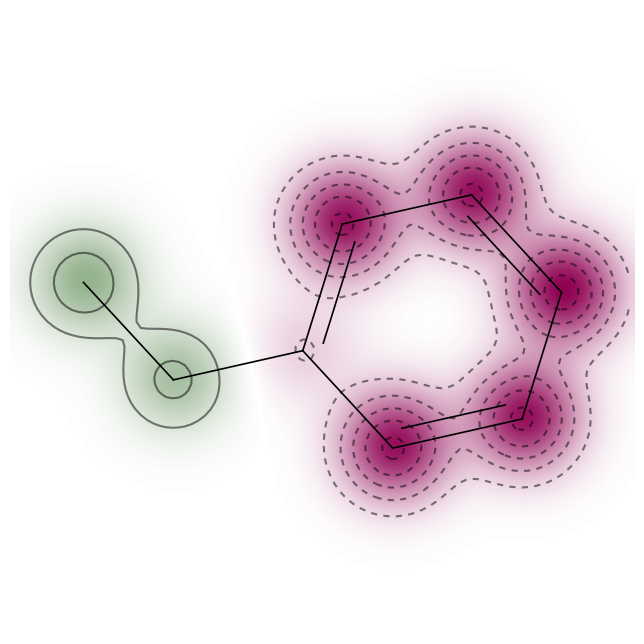

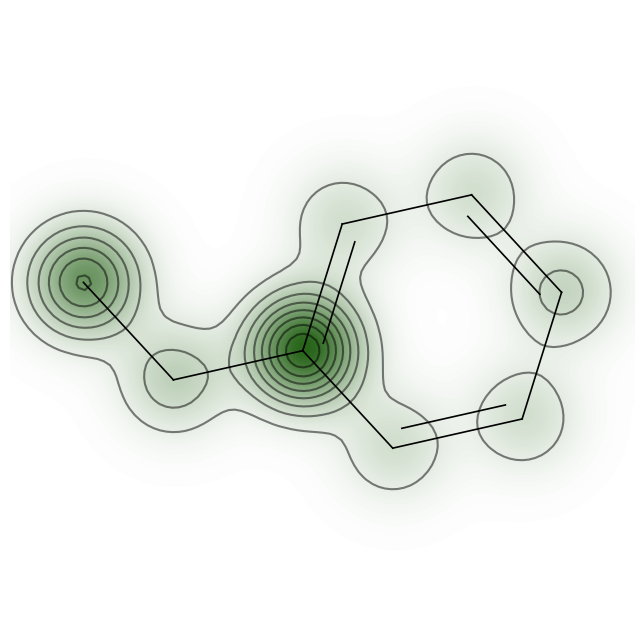

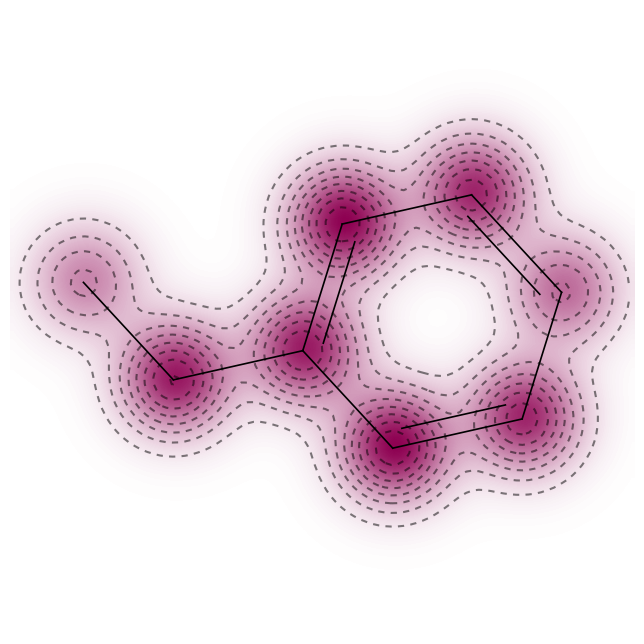

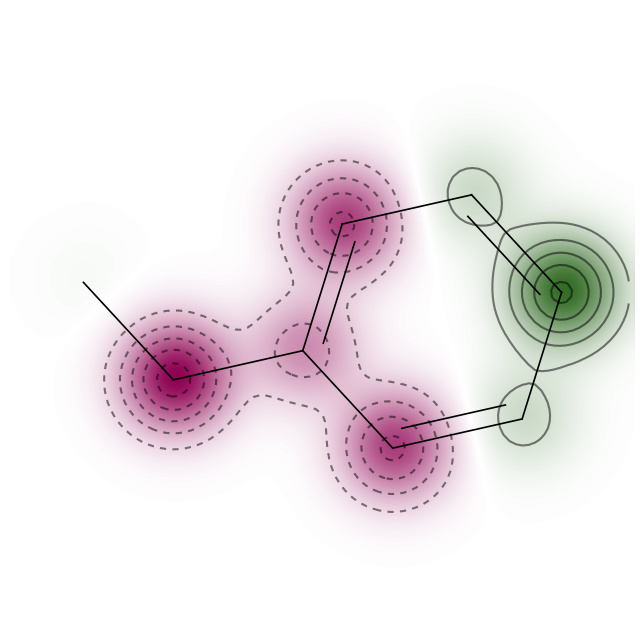

In [51]:
from rdkit import Chem
import os
import joblib
import numpy as np

# Random SMILES to test
test_smi = "CCc1ccccc1"  # SMILES for ethylbenzene

# Directory and model file paths
MODEL_DIR = "../dev_tox/models"
MODEL_DICT = {
    'Overall Toxicity': [os.path.join(MODEL_DIR, 'ECFP4_overall_tox_svm.joblib')],
    'First Trimester Toxicity': [os.path.join(MODEL_DIR, 'ECFP4_first_trimester_svm.joblib')],
    'Second Trimester Toxicity': [os.path.join(MODEL_DIR, 'ECFP4_second_trimester_svm.joblib')],
    'Third Trimester Toxicity': [os.path.join(MODEL_DIR, 'ECFP4_third_trimester_svm.joblib')],
}

# Selected features files for each model
SELECTED_FEATURES_FILES = {
    'Overall Toxicity': os.path.join(MODEL_DIR, 'selected_features_overall_tox_ecfp4.npy'),
    'First Trimester Toxicity': os.path.join(MODEL_DIR, 'selected_features_first_tri_ecfp4.npy'),
    'Second Trimester Toxicity': os.path.join(MODEL_DIR, 'selected_features_second_tri_ecfp4.npy'),
    'Third Trimester Toxicity': os.path.join(MODEL_DIR, 'selected_features_third_tri_ecfp4.npy'),
}

# Test get_prob_map function for all models
for model_name, model_path_list in MODEL_DICT.items():
    model_path = model_path_list[0]  # Get model file path
    selected_features_file = SELECTED_FEATURES_FILES[model_name]  # Get selected features file path

    print(f"Testing get_prob_map for {model_name}...")

    try:
        # Load the model
        model_data = joblib.load(model_path)
        model = model_data['model']  # Extract the trained model

        # Call get_prob_map function
        svg_output = get_prob_map(model, test_smi, selected_features_file)

        # Check if SVG output is generated
        if svg_output:
            print(f"Successfully generated similarity map for {model_name}.\nSample of SVG output:\n{svg_output[:200]}...\n")
        else:
            print(f"Failed to generate similarity map for {model_name}. SVG output is empty.\n")
    except Exception as e:
        print(f"Error testing {model_name}: {e}\n")


In [49]:
# Testing the get_prob_map function for all models
# Random SMILES to test
test_smi = "CCc1ccccc1"  # SMILES for ethylbenzene

# Test get_prob_map function for all models
for model_name, model_path_list in MODEL_DICT.items():
    model_path = model_path_list[0]  # Get model file path
    selected_features_file = SELECTED_FEATURES_FILES[model_name]  # Get selected features file path

    print(f"Testing get_prob_map for {model_name}...")

    try:
        # Load the model
        model_data = joblib.load(model_path)
        model = model_data['model']  # Extract the trained model

        # Call get_prob_map function with three arguments
        svg_output = get_prob_map(model, test_smi, selected_features_file)

        # Check if SVG output is generated
        if svg_output:
            print(f"Successfully generated similarity map for {model_name}.\nSample of SVG output:\n{svg_output[:200]}...\n")
        else:
            print(f"Failed to generate similarity map for {model_name}. SVG output is empty.\n")
    except Exception as e:
        print(f"Error testing {model_name}: {e}\n")

Testing get_prob_map for Overall Toxicity...
Error testing Overall Toxicity: get_prob_map() takes 2 positional arguments but 3 were given

Testing get_prob_map for First Trimester Toxicity...
Error testing First Trimester Toxicity: get_prob_map() takes 2 positional arguments but 3 were given

Testing get_prob_map for Second Trimester Toxicity...
Error testing Second Trimester Toxicity: get_prob_map() takes 2 positional arguments but 3 were given

Testing get_prob_map for Third Trimester Toxicity...
Error testing Third Trimester Toxicity: get_prob_map() takes 2 positional arguments but 3 were given

